In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model.cuda()

# MobileNetV2
# ├── features
# │   ├──  0: C-B-A
# │   ├──  1: InvertedResidual
# │   ├── ...
# │   ├── 17: InvertedResidual
# │   ├── 18: C-B-A
# ├── classifier
# │   ├──  0: Dropout
# │   └──  1: Linear


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/hsujenlung/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 80.3MB/s]
/home/hsujenlung/miniconda3/envs/Roy/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

17


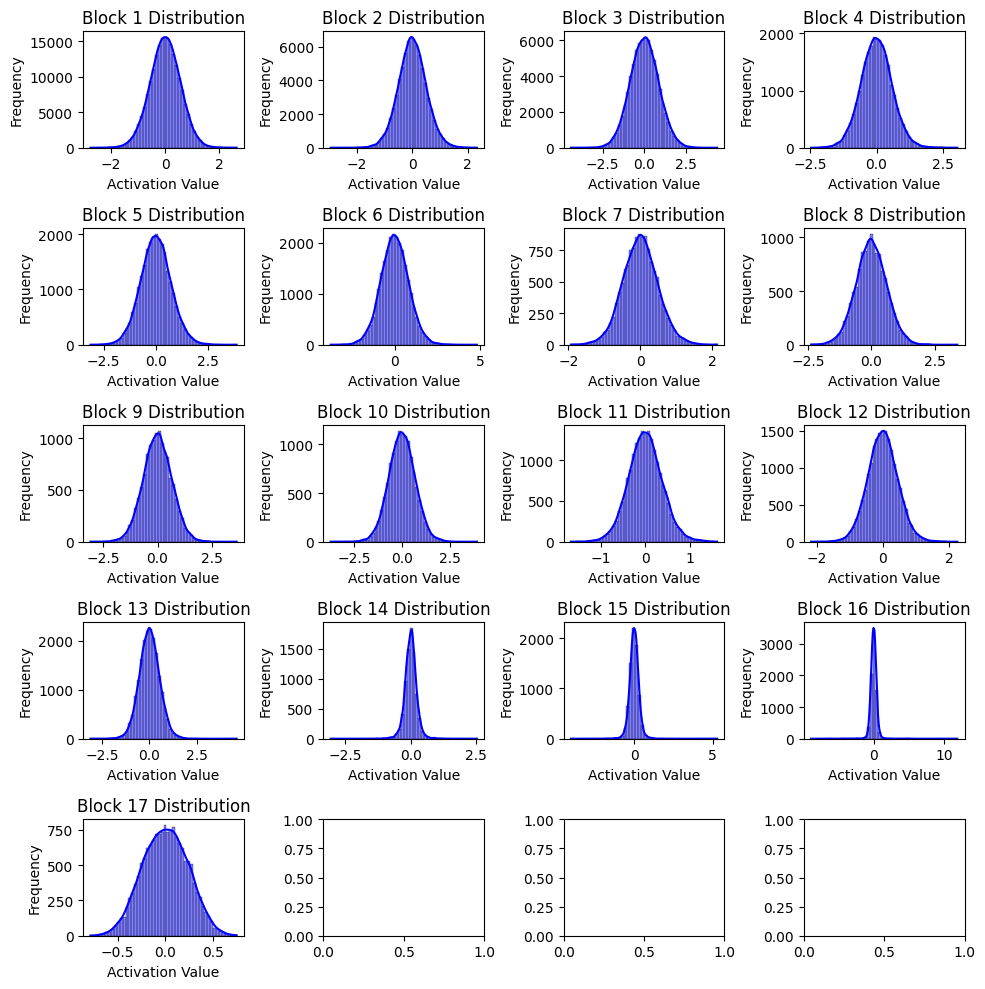

In [3]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torchvision.models as models
from torchvision.models.mobilenetv2 import InvertedResidual


from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)


# 用來存儲各層輸出的列表
activations = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn(module, input, output):
    activations.append(output)

# 設置鉤子，將鉤子添加到每個 stage 和 unit
hooks = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 遍歷 MobileNetV2 的 features 部分
for idx, layer in enumerate(model.features):
    if isinstance(layer, InvertedResidual):
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

print(len(hooks))

# 隨機生成輸入，形狀為 (1, 3, 224, 224)
input_tensor = torch.randn(1, 3, 224, 224)

# 前向傳遞，這將觸發鉤子
model(input_tensor)

# 繪製每個 block 的數據分佈圖（直方圖）
fig, axes = plt.subplots(5, 4, figsize=(10, 10))  # 設置 8x4 子圖來顯示 32 個直方圖
axes = axes.flatten()

# 遍歷每個 block 的激活並繪製分佈圖
for i in range(min(20, len(activations))):  # 確保最多繪製 32 張圖
    activation = activations[i].cpu().detach().numpy()  # 取得激活並轉換為 numpy 格式
    flattened_activation = activation.flatten()  # 展平為一維數據
    
    # 繪製數據分佈，使用 seaborn 畫出密度圖
    sns.histplot(flattened_activation, kde=True, ax=axes[i], color='blue', bins=50)
    axes[i].set_title(f'Block {i+1} Distribution')
    axes[i].set_xlabel('Activation Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 釋放鉤子
for hook in hooks:
    hook.remove()

In [4]:
import torch
import numpy as np
import pandas as pd
import torchvision.models as models

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(5)  # 設定固定種子

# 用來存儲層輸出的列表
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output)

# 設置鉤子，將鉤子添加到每個 unit（block）
hooks_pretrained = []

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 清空之前的激活
    activations_pretrained.clear()

    # 如果有自訓練權重，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    # 遍歷 MobileNetV2 的 features 部分
    for idx, layer in enumerate(model.features):
        if isinstance(layer, InvertedResidual):
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)
    print(len(hooks))
    
    # 隨機生成輸入，形狀為 (1, 3, 224, 224)
    input_tensor = torch.randn(1, 3, 224, 224)

    # 前向傳遞，這將觸發鉤子
    model(input_tensor)

    # 釋放鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)  # 預訓練權重

activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

# 統計信息
stats = []

num_plots = min(17, len(activations_pretrained_copy))

for i in range(num_plots):  
    # 取得預訓練激活並轉換為 numpy 格式
    activation_pretrained = activations_pretrained_copy[i].cpu().detach().numpy()
    flattened_activation_pretrained = activation_pretrained.flatten()

    # 計算均值和標準差
    mean_pretrained = np.mean(flattened_activation_pretrained)
    std_pretrained = np.std(flattened_activation_pretrained)

    # 獲取輸出形狀
    output_shape = activation_pretrained.shape

    # 存儲統計信息
    stats.append([i+1, output_shape, mean_pretrained, std_pretrained])

# 創建 DataFrame 並顯示
columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained']
df_stats = pd.DataFrame(stats, columns=columns)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Activation Statistics", dataframe=df_stats)  # 顯示數據表格

display(df_stats.style.hide(axis="index"))



17


block_index,output shape,mean of pretrained,std of pretrained
1,"(1, 16, 112, 112)",-0.000000,0.557453
2,"(1, 24, 56, 56)",0.000000,0.501783
3,"(1, 24, 56, 56)",0.000000,0.855974
4,"(1, 32, 28, 28)",-0.000000,0.581193
5,"(1, 32, 28, 28)",-0.000000,0.718434
6,"(1, 32, 28, 28)",-0.000000,0.805645
7,"(1, 64, 14, 14)",-0.000000,0.485375
8,"(1, 64, 14, 14)",-0.000000,0.600512
9,"(1, 64, 14, 14)",-0.000000,0.641291
10,"(1, 64, 14, 14)",-0.000000,0.679993


# KS Test

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torchvision.models.mobilenetv2 import InvertedResidual

import torch
import numpy as np
import pandas as pd
from pytorchcv.model_provider import get_model as ptcv_get_model
import torchvision.models as models
from scipy.stats import ttest_ind

import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)  # 保證所有操作可重現
set_seed(3)  # 設定固定種子

# 設定 device 為 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# 用來存儲層輸出的列表（轉移到 CPU 以節省 GPU 記憶體）
activations_pretrained = []
activations_finetuned = []

# 定義鉤子函數來保存每個 block 的輸出
def hook_fn_pretrained(module, input, output):
    # 將 output detach、clone 並移到 CPU（避免持續佔用 GPU 記憶體）
    activations_pretrained.append(output.detach().clone().cpu())

# 設置鉤子列表
hooks_pretrained = []
hooks_finetuned = []

import torchvision.transforms as T
from PIL import Image
def read_image(path):
    image = Image.open(path).convert('RGB')
    image = T.Compose([
        T.Resize(224 + 224// 8, interpolation=T.InterpolationMode.BILINEAR),
        T.CenterCrop(224),
        T.ToTensor(),
        # T.Normalize(mean=self.norm_mean, std=self.norm_std),
    ])(image)
    return image

# 判斷有無子模組
def has_children(module):
    return len(list(module.children())) > 0

# 定義一個函數來加載權重並獲取激活分佈
def get_activations_from_model(model, hook_fn, hooks, weights=None):
    # 根據 hook_fn 判斷要清空哪個全域列表
    if hook_fn == hook_fn_pretrained:
        activations_pretrained.clear()
    
    # 如果有權重檔案，則加載它們
    if weights:
        checkpoint = torch.load(weights, weights_only=True)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    # 遍歷 MobileNetV2 的 features 部分
    for idx, layer in enumerate(model.features):
        if isinstance(layer, InvertedResidual):
            hook = layer.register_forward_hook(hook_fn)
            hooks.append(hook)
    print(len(hooks))
    
    # 生成輸入 tensor，並將其放到 device 上
    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Real_youtube/000/000.png'
    # path = '/ssd2/DeepFakes_may/FF++/c23_crop_face/train/Deepfakes/000_003/000.png'
    # image = read_image(path).to(device)
    # image = image.unsqueeze(0)
    # print(image.shape)
    # model(image)
    model(input_tensor)
    
    # 移除所有鉤子
    for hook in hooks:
        hook.remove()

# 預訓練權重的模型
def load_pretrained_model():
    from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
    model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    return model

# 獲取預訓練權重的激活
pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, hooks_pretrained)
activations_pretrained_copy = activations_pretrained.copy()  # 儲存預訓練的激活

from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    # Pretrained 模型
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre  = activations_pretrained_copy[i].numpy().flatten()

    # act_before_pre = remove_outliers(act_before_pre)
    # act_after_pre = remove_outliers(act_after_pre)

    # Mannwhitneyu
    # u_stat_pre, p_val_pre = mannwhitneyu(act_before_pre, act_after_pre, alternative='two-sided')

    # KS
    u_stat_pre, p_val_pre = ks_2samp(act_before_pre, act_after_pre)
    sig_pre = "*" if p_val_pre < 0.05 else ""
    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)

    # 使用 pretrained 模型當前 block 的輸出形狀作為參考
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i+1, output_shape, mean_pre, std_pre, sig_pre, p_val_pre])

# 建立 DataFrame
columns = ['block_index', 
           'output shape', 
           'mean of pretrained', 'std of pretrained', 'sig of pretrained', 'p_val_pre']
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))



17


block_index,output shape,mean of pretrained,std of pretrained,sig of pretrained,p_val_pre
2,"torch.Size([1, 24, 56, 56])",0.000000,0.501783,*,0.000000
3,"torch.Size([1, 24, 56, 56])",0.000000,0.854038,*,0.000000
4,"torch.Size([1, 32, 28, 28])",-0.000000,0.581193,*,0.000000
5,"torch.Size([1, 32, 28, 28])",-0.000000,0.720022,*,0.000000
6,"torch.Size([1, 32, 28, 28])",-0.000000,0.804392,*,0.000000
7,"torch.Size([1, 64, 14, 14])",-0.000000,0.485375,*,0.000000
8,"torch.Size([1, 64, 14, 14])",-0.000000,0.603297,*,0.000000
9,"torch.Size([1, 64, 14, 14])",-0.000000,0.646882,*,0.003175
10,"torch.Size([1, 64, 14, 14])",-0.000000,0.681047,,0.270399
11,"torch.Size([1, 96, 14, 14])",0.000000,0.377304,*,0.000000


# 距離方法 EMD

In [16]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
from scipy.stats import wasserstein_distance, entropy  # 用於計算 EMD 和 KL 散度
from scipy.spatial.distance import jensenshannon  # JS 散度
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(5)

device = torch.device("cpu")

activations_pretrained = []

def hook_fn_pretrained(module, input, output):
    activations_pretrained.append(output.detach().clone().cpu())

def has_children(module):
    return len(list(module.children())) > 0

def get_activations_from_model(model, hook_fn, hooks, weights=None):
    activations_pretrained.clear()

    if weights:
        checkpoint = torch.load(weights, weights_only=True, map_location=device)
        model.load_state_dict(checkpoint['state_dict'], strict=False)

    for stage in model.children():
        if isinstance(stage, torch.nn.Sequential):
            for unit in stage:
                if has_children(unit):
                    hook = unit.register_forward_hook(hook_fn)
                    hooks.append(hook)

    input_tensor = torch.randn(1, 3, 224, 224, device=device)
    model(input_tensor)

    for hook in hooks:
        hook.remove()

def load_pretrained_model():
    from torchvision.models import resnet50, ResNet50_Weights
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    return model

def emd_distance(features1, features2):
    return wasserstein_distance(features1.flatten(), features2.flatten())

def to_probability_minmax(features):
    features = (features - np.min(features)) / (np.max(features) - np.min(features) + 1e-10)
    return features / np.sum(features)

def total_variation_distance(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return 0.5 * np.sum(np.abs(p1 - p2))

def js_divergence(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return jensenshannon(p1, p2)

def kl_divergence(features1, features2):
    if len(features1) != len(features2):
        return 9999999
    else:
        p1, p2 = to_probability_minmax(features1), to_probability_minmax(features2)
        return entropy(p1 + 1e-10, p2 + 1e-10)

def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]

pretrained_model = load_pretrained_model()
get_activations_from_model(pretrained_model, hook_fn_pretrained, [])
activations_pretrained_copy = activations_pretrained.copy()

rows = []
n = len(activations_pretrained_copy)
for i in range(1, n):
    act_before_pre = activations_pretrained_copy[i-1].numpy().flatten()
    act_after_pre = activations_pretrained_copy[i].numpy().flatten()

    # act_before_pre = remove_outliers(act_before_pre)
    # act_after_pre = remove_outliers(act_after_pre)

    emd_pre = emd_distance(act_before_pre, act_after_pre)
    tv_pre = total_variation_distance(act_before_pre, act_after_pre)
    js_pre = js_divergence(act_before_pre, act_after_pre)
    kl_pre = kl_divergence(act_before_pre, act_after_pre)

    sig_pre = "*" if emd_pre > 0.005 else ""
    # sig_pre = "*" if tv_pre > 0.1 else ""
    # sig_pre = "*" if js_pre > 0.15 else ""
    # sig_pre = "*" if kl_pre > 0.2 else ""

    mean_pre = np.mean(act_after_pre)
    std_pre = np.std(act_after_pre)
    output_shape = activations_pretrained_copy[i].shape
    
    rows.append([i, output_shape, mean_pre, std_pre, emd_pre, tv_pre, js_pre, kl_pre, sig_pre])

columns = ['block_index', 'output shape', 'mean of pretrained', 'std of pretrained', 
           'EMD of pretrained', 'TV of pretrained', 'JS of pretrained', 'KL of pretrained', 'sig_pre']
df_stats = pd.DataFrame(rows, columns=columns)

display(df_stats.style.hide(axis="index"))


block_index,output shape,mean of pretrained,std of pretrained,EMD of pretrained,TV of pretrained,JS of pretrained,KL of pretrained,sig_pre
1,"torch.Size([1, 256, 56, 56])",0.178947,0.242255,0.026814,0.150498,0.210669,0.248528,*
2,"torch.Size([1, 256, 56, 56])",0.194650,0.244128,0.015705,0.137177,0.215918,0.302725,*
3,"torch.Size([1, 512, 28, 28])",0.103417,0.160970,0.091233,9999999.000000,9999999.000000,9999999.000000,*
4,"torch.Size([1, 512, 28, 28])",0.117249,0.172351,0.013832,0.225702,0.301125,0.672211,*
5,"torch.Size([1, 512, 28, 28])",0.115409,0.177706,0.005347,0.211622,0.273886,0.804111,*
6,"torch.Size([1, 512, 28, 28])",0.112861,0.176028,0.002739,0.200248,0.279534,0.827597,
7,"torch.Size([1, 1024, 14, 14])",0.071889,0.126512,0.040971,9999999.000000,9999999.000000,9999999.000000,*
8,"torch.Size([1, 1024, 14, 14])",0.069914,0.119669,0.004853,0.305349,0.368264,1.457186,
9,"torch.Size([1, 1024, 14, 14])",0.064639,0.115538,0.005295,0.294398,0.354855,1.529553,*
10,"torch.Size([1, 1024, 14, 14])",0.057087,0.109800,0.007666,0.286634,0.351888,1.635416,*
